In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

In [ ]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 1.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [ ]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn import preprocessing


In [ ]:
#para a métrica de avaliação do modelo:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#Para o pipeline:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/dataset_final_merge.csv', dtype=str, delimiter=',')

In [ ]:
data.shape

(1009714, 42)

# Processamento / Tratamento dos dados


Vamos copiar o DataFrame importado para ocorra algum erro, não seja necessário fazer novamente a importação, que é mais lenta.

In [ ]:
#criar copia pra nao ter q importar toda hora o df
copia = data.copy()
copia, copia.shape

(        cnpj_basico ordem  dv  ... renda_media_mensal          pib   populacao
 0          39304534  0001  47  ...            4427.54  714683362.0  12325232.0
 1          39304564  0001  53  ...            4427.54  714683362.0  12325232.0
 2          39304616  0001  91  ...            4427.54  714683362.0  12325232.0
 3          39304717  0001  62  ...            4427.54  714683362.0  12325232.0
 4          37419658  0003  04  ...            4427.54  714683362.0  12325232.0
 ...             ...   ...  ..  ...                ...          ...         ...
 1009709    35607687  0001  02  ...            2458.57      57006.0      2403.0
 1009710    36984322  0001  60  ...            2458.57      57006.0      2403.0
 1009711    37588106  0001  68  ...            2458.57      57006.0      2403.0
 1009712    37917664  0001  20  ...            2458.57      57006.0      2403.0
 1009713    38137283  0001  90  ...            2458.57      57006.0      2403.0
 
 [1009714 rows x 42 columns], (1009714

In [ ]:
data['data_sit_cad'] = pd.to_datetime(data['data_sit_cad'], infer_datetime_format=True, errors='coerce')
data['inicio_atividade'] = pd.to_datetime(data['inicio_atividade'], infer_datetime_format=True, errors='coerce')

In [ ]:
data.isna().sum()

cnpj_basico                 0
ordem                       0
dv                          0
matriz_filial               0
nome                   484803
situacao_cadastral          0
data_sit_cad             5251
motivo_sit_cad              0
cidade_exterior       1009714
cod_pais              1009511
inicio_atividade            0
cnae_principal              0
cnae_secund            564784
tipo                     4094
logradouro                  5
numero                      6
complemento            650485
bairro                   2515
cep                         1
uf                          0
municipio_rfb               0
ddd                    168140
tel                    168135
ddd2                   893527
tel2                   893717
dddfax                 830562
fax                    830536
email                  314273
sit_especial          1009713
data_sit_especial     1009713
razao_social           901749
nat_jur                901749
qual_resp              901749
capital_so

Vamos ver a cardinalidade/valores únicos das features:

In [ ]:
data.nunique()

cnpj_basico           988293
ordem                   2487
dv                       100
matriz_filial              2
nome                  478756
situacao_cadastral         2
data_sit_cad           13529
motivo_sit_cad             2
cidade_exterior            0
cod_pais                  11
inicio_atividade       16233
cnae_principal          1266
cnae_secund           137475
tipo                     264
logradouro            228651
numero                 23362
complemento           110308
bairro                 66702
cep                   159878
uf                         1
municipio_rfb            645
ddd                      200
tel                   582624
ddd2                      89
tel2                   57960
dddfax                   185
fax                    57731
email                 501935
sit_especial               1
data_sit_especial          1
razao_social          107717
nat_jur                   27
qual_resp                 19
capital_social          1229
porte_empresa 

In [ ]:
pd.DataFrame(copia[['cnpj_basico', 'ordem', 'dv', 'cnae_secund', 'nome', 'numero', 'logradouro', 'razao_social', 'bairro']].nunique()).T

,cnpj_basico,ordem,dv,cnae_secund,nome,numero,logradouro,razao_social,bairro
0,988293,2487,100,137475,478756,23362,228651,107717,66702


In [ ]:
1 - (data[['cidade_exterior', 'cod_pais', 'ente_resp', 'sit_especial', 'data_sit_especial']].count()/len(copia))

cidade_exterior      1.000000
cod_pais             0.999799
ente_resp            0.999987
sit_especial         0.999999
data_sit_especial    0.999999
dtype: float64

Devida a alta cardinalidade de cnae secundário, vou deletar essa coluna, pois ela tem correlação com o cnae principal e possui 137.475 valores únicos a princípio, logo aumentaria demasiadamente as dimensões quando realizar *one hot encoding*. As features cidade_exterior, data_sit_especial e municipio_rfb também serão deletadas pois são compostas quase que totalmente por missing values ou trazem informações redudantes. A coluna uf e uf.1 só tem um tipo de valor, portanto não tem variância nos dados, contém apenas o estado que é SãoPaulo. Ela também poderá ser deletada. A coluna razão especial também só possui 1 valor, logo não traz informação discriminante. E a coluna situação cadastral traz informação redudante da coluna motivo_sit_cad, que detalha o motivo da situação cadastral.

In [ ]:
features_deletadas = ['codigoibge', 'cnpj_basico', 'ordem', 'cod_pais', 'ente_resp',
                      'municipio_rfb','data_sit_especial','cidade_exterior',
                      'cnae_secund', 'situacao_cadastral', 'uf', 'uf.1', 'sit_especial',  'dv', 'nome', 'numero', 'logradouro', 'bairro', 'razao_social']
data.drop(axis=1, columns=features_deletadas, inplace=True)
data.shape #add 

(1009714, 23)

Separando os dados com shuffle=False para nao ocorrer vazamento de dados. Necessário fazer antes das imputações para não levar a vazamento de dados entre treino e teste

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.1, random_state=0, shuffle=False) #Aqui tem que ser false pois os dados têm um componente de serie temporal

'train set', train_set.shape, 'test set ', test_set.shape

('train set', (908742, 23), 'test set ', (100972, 23))

### Sabemos que computadores não entendem dados em texto, então terei que converte as variáveis em texto para números. Primeiro irei transformar features telefone, email, faz em binárias. O racicionio por trás de transforma-las em binárias é porque pode ser que empresas que tenham telefone, email, fax tenham melhor comunicação com os clientes e assim melhor chance de prosperarem. Essa variáveis são categóricas sem ordem, ou seja, são variáveis nominais (com telefone ou sem telefone) que serão transformadas em binárias (0 ou 1). 

### Também imputarei valores ao que é NaN das variáveis, pois o scikit-learn não consegue trabalhar com NaN. Provavelmente os valores Nan presentes na tabela é porque não existem mesmo, então colocar 0 para representar a inexistência desses valores e tornar os dados compatíveis com o scikit-learn.

### Um modo fácil de converte as variáveis é criar um mapeamento entre os valores em texto e números. Esse tipo de método também é conhecido como Label Encoding. O scikit learn tem um método cahamado LabelEncoder()

## Métodos criados:

Transformer para transformar em binario e preencher nan

In [ ]:
class feat_binario1(TransformerMixin):

    def __init__(self):
      return None
        #self.coluna = coluna
        #self.coluna = list(self.coluna)
    def fit(self, X, y=0):
        # 'stateless'
        return self

    def transform(self, X, y=0):
        
        #primeiro transforma o que nao é nan em 1:
        filtro_notna = X.notna() #filtrar o que NAO é NaN
        X[filtro_notna] = 1
  #agora é a vez do que é NaN:
        filtro_linhas_nan = X.isna() #filtrar as linhas nan de telefone
        X[filtro_linhas_nan] = 0
  #finalmente transforma em int:
        X = X.astype(str)
        # assumes X is a DataFrame
        # Xcols = X[self.cols]
        return X
        
#Transformer para mudar o tipo das features
class muda_dtype(TransformerMixin):

    def __init__(self, dtype=float):
      self.dtype = dtype
    
    def fit(self, X):
      return self #faz nada
    
    def transform(self, X):
      X = X.astype(self.dtype)
      return X

StandardScaler pra plotar gráficos, pois retorna como dataframe

In [ ]:
class DFStandardScaler(TransformerMixin):
    # StandardScaler but for pandas DataFrames

    def __init__(self):
        self.ss = None
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X)
        self.mean_ = pd.Series(self.ss.mean_, index=X.columns)
        self.scale_ = pd.Series(self.ss.scale_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss, index=X.index, columns=X.columns)
        return Xscaled

## Imputações / missing values:

### variáveis de contato

Algumas features com alta cardinalidade podem inflar demasiadamente as dimensões para que o algoritimo possa aprender os padrões dos dados. Portanto, telefone, numero de fax, email, segundo telefone, serão interpretadas de modo binário. Talvez um cnjp ter mais meios de comunicação transmita algum sinal que possa ajudar o algoritimo a discriminar se uma empresa provavelmente está ativa ou não.




In [ ]:
#Vamos transformar nans em zeros e o restante em 1, ou seja, tornar a feature binária
insta = feat_binario1()
train_set.loc[:, ['ddd', 'tel', 'ddd2', 'tel2', 'dddfax', 'fax', 'email']] = insta.fit_transform(train_set.loc[:, ['ddd', 'tel', 'ddd2', 'tel2', 'dddfax', 'fax', 'email']])
train_set.loc[:, ['ddd', 'tel', 'ddd2', 'tel2', 'dddfax', 'fax', 'email']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


,ddd,tel,ddd2,tel2,dddfax,fax,email
0,1,1,0,0,0,0,1
1,1,1,0,0,0,0,1
2,1,1,0,0,0,0,1
3,1,1,0,0,0,0,1
4,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...
908737,1,1,0,0,1,1,1
908738,1,1,0,0,1,1,0
908739,1,1,0,0,0,0,1
908740,1,1,0,0,1,1,0


In [ ]:
#missing values 
train_set.isna().sum()

matriz_filial              0
data_sit_cad            4847
motivo_sit_cad             0
inicio_atividade           0
cnae_principal             0
tipo                    3423
complemento           579446
cep                        1
ddd                        0
tel                        0
ddd2                       0
tel2                       0
dddfax                     0
fax                        0
email                      0
nat_jur               808848
qual_resp             808848
capital_social        808848
porte_empresa         808848
municipio                  0
renda_media_mensal         0
pib                        0
populacao                  0
dtype: int64

Devido a alta cardinalidade de algumas variáveis, resolvi classificar o que é missing value como 0 e o que é preenchido como 1. O método feat_binario() primeiro transforma o que é nulo no número 0 e depois o que não é nulo no número 1. Esse método é diferente por exemplo do que o LabelEncoder() do Sklearn, que precisa que a feature seja binário, por exemplo ("homem"/"mulher" ou "tóquio/rio de janeiro"). 

## Variaveis complemento , tipo, porte, natureza juridica e qual resp fillina; já data_sit_cad nao será usada no modelo


In [ ]:
train_set[['tipo', 'complemento']].isna().sum()

tipo             3423
complemento    579446
dtype: int64

In [ ]:
train_set.loc[:, ['tipo', 'complemento', 'porte_empresa', 'nat_jur', 'qual_resp']] = train_set.loc[:, ['tipo', 'complemento', 'porte_empresa', 'nat_jur', 'qual_resp']].fillna('missing') #['tipo', 'complemento', 'porte_empresa', 'nat_jur', 'qual_resp']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [ ]:
#train_set['capital_social']  será tratada com imputação da mediana no pipeline e demais quantitativas

In [ ]:
train_set[['tipo', 'complemento', 'porte_empresa', 'nat_jur', 'qual_resp']]

,tipo,complemento,porte_empresa,nat_jur,qual_resp
0,RUA,SALA 13,05,2062,49
1,RUA,missing,01,2135,50
2,AVENIDA,missing,03,2062,49
3,RUA,missing,01,2135,50
4,RUA,missing,03,2305,65
...,...,...,...,...,...
908737,RUA,missing,missing,missing,missing
908738,RUA,missing,missing,missing,missing
908739,RUA,missing,missing,missing,missing
908740,RUA,missing,missing,missing,missing


In [ ]:
train_set[['tipo', 'complemento', 'porte_empresa', 'nat_jur', 'qual_resp']].isna().sum()

tipo             0
complemento      0
porte_empresa    0
nat_jur          0
qual_resp        0
dtype: int64

In [ ]:
train_set['cep'] = train_set['cep'].fillna(method='bfill')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_set.isna().sum()

matriz_filial              0
data_sit_cad            4847
motivo_sit_cad             0
inicio_atividade           0
cnae_principal             0
tipo                       0
complemento                0
cep                        0
ddd                        0
tel                        0
ddd2                       0
tel2                       0
dddfax                     0
fax                        0
email                      0
nat_jur                    0
qual_resp                  0
capital_social        808848
porte_empresa              0
municipio                  0
renda_media_mensal         0
pib                        0
populacao                  0
dtype: int64

In [ ]:
#DATA_SIT_CAD não será usada para treinamento do modelo

## Fim de imputação. Inicio de Feature engineering





In [ ]:
train_set[['tipo', 'complemento']].nunique()

tipo              249
complemento    103941
dtype: int64

Há um problema na coluna tipo que requer preprocessamento. Nela há uma mistura de números e letras que aumentar a cardinalidade dos dados. Por exemplo, há "11A travessa" e "10A travessa", quando se poderia apenas ter "travessa". Assim, há 129 variações da coluna 'tipo', vamos tentar reduzir essa cardinalidade com o REGEX. 

In [ ]:
train_set['tipo'].value_counts()

RUA            642727
AVENIDA        170603
ESTRADA         18676
SITIO           12267
ALAMEDA         11203
                ...  
FONTE               1
BALNEÁRIO           1
1O ALTO             1
CAMPUS              1
7A TRAVESSA         1
Name: tipo, Length: 249, dtype: int64

Abaixo podemos ver que conseguimos reduzir para as variações da coluna 'tipo' e assim continuamos com a mesma quantidade de linhas. É importante reduzir a quantidade de tipos, pois quando fizermos o one hot encoding, cada valor se tornará uma dimensão. Assim tentamos reduzir o efeito da 'maldição da alta dimensionalidade' no nosso classificador linear.

In [ ]:
train_set.loc[: , 'tipo'] = train_set.loc[:, 'tipo'].str.replace(r'^\d[^ ]* ', '').str.strip() #.value_counts().sort_index()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
train_set['tipo'].isna().sum(), train_set['tipo'].nunique()

(0, 204)

Vamos tentar agora também aproveitar a coluna complemento. Ela também possui alta cardinalidade que pode confundir nosso classificador. Ela possui 15,247 valores distintos, em um total de 107.965 valores incluindo nan e 63.044 missing values (nan).


## Variavel COMPLEMENTO



variavel de segurança, abaixo

In [ ]:
X = train_set.copy() #copia de segurança!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
train_set['complemento'] = train_set['complemento'].str.replace(r'\d+', '').str.strip() #remove espaços no inicio e fim da string

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_set['complemento'] = train_set['complemento'].str.extract(r'\b([a-zA-Z]{,20})\b').fillna('numero') #Numero PORQUE havia valores dentro de complemento que eram números, dos mais variados, aumentando muito a cardinalidade, logo só quero o que é mais comum.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#Vamos reduzir mais, pegando só as 2 primeiras letras do complemento
train_set['complemento'] = train_set['complemento'].str[:2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_set['complemento'].nunique()

363

In [ ]:
train_set[train_set.index.isin([581921])] #verifica o que há na coluna complemento com índice 581921, há apenas espaço.

,matriz_filial,data_sit_cad,motivo_sit_cad,inicio_atividade,cnae_principal,tipo,complemento,cep,ddd,tel,ddd2,tel2,dddfax,fax,email,nat_jur,qual_resp,capital_social,porte_empresa,municipio,renda_media_mensal,pib,populacao
581921,2,1995-03-31,1,1990-06-26,4754701,AVENIDA,nu,09361340,0,0,0,0,0,0,0,2062,49,"0,00",05,MAUA,2252.64,15287483.0,477552.0


In [ ]:
train_set['complemento'].value_counts().head(20), train_set['complemento'].nunique()

(mi    579446
 CA     57784
 AP     56950
 SA     41155
 CO     33794
 AN     24215
 LO     22638
 BL     14829
 FU      9137
 A       5049
 KM      4937
 BO      4890
 TE      4350
 nu      3976
 QU      3472
 SI      3211
 GA      2517
 LE      2500
 ZO      2485
 PA      1998
 Name: complemento, dtype: int64, 363)

Vamos mudar os dtypes das colunas a seguir

In [ ]:
train_set['capital_social'] = train_set['capital_social'].str.replace(',', '.')  # evita o erro 'ValueError: could not convert string to float: '000000300000,00'

colunas_para_mudar_dtype = ['capital_social', 
                           'pib', 'populacao', 'renda_media_mensal']
                          
muda = muda_dtype()
train_set[colunas_para_mudar_dtype] = muda.fit_transform(train_set[colunas_para_mudar_dtype])
train_set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,matriz_filial,data_sit_cad,motivo_sit_cad,inicio_atividade,cnae_principal,tipo,complemento,cep,ddd,tel,ddd2,tel2,dddfax,fax,email,nat_jur,qual_resp,capital_social,porte_empresa,municipio,renda_media_mensal,pib,populacao
0,1,2020-10-05,0,2020-10-05,6810202,RUA,SA,04110020,1,1,0,0,0,0,1,2062,49,300000.0,05,SAO PAULO,4427.54,714683362.0,12325232.0
1,1,2020-10-05,0,2020-10-05,1091102,RUA,mi,02814030,1,1,0,0,0,0,1,2135,50,1000.0,01,SAO PAULO,4427.54,714683362.0,12325232.0
2,1,2020-10-05,0,2020-10-05,5611201,AVENIDA,mi,02520100,1,1,0,0,0,0,1,2062,49,50000.0,03,SAO PAULO,4427.54,714683362.0,12325232.0
3,1,2020-10-05,0,2020-10-05,4724500,RUA,mi,08475410,1,1,0,0,0,0,1,2135,50,3000.0,01,SAO PAULO,4427.54,714683362.0,12325232.0
4,2,2020-10-05,0,2020-10-05,4635403,RUA,mi,04286100,1,1,0,0,0,0,1,2305,65,104500.0,03,SAO PAULO,4427.54,714683362.0,12325232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908737,1,2012-12-31,1,2012-07-08,9492800,RUA,mi,16901012,1,1,0,0,1,1,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
908738,1,2012-12-31,1,2012-07-12,9492800,RUA,mi,16901440,1,1,0,0,1,1,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
908739,1,2015-03-17,1,2012-07-12,9511800,RUA,mi,16900015,1,1,0,0,0,0,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
908740,1,2012-12-31,1,2012-07-12,9492800,RUA,mi,16900660,1,1,0,0,1,1,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0


In [ ]:
train_set.nunique(), #podemos ver que diversas features agora se tornaram binárias

(matriz_filial              2
 data_sit_cad           13396
 motivo_sit_cad             2
 inicio_atividade       16095
 cnae_principal          1259
 tipo                     204
 complemento              363
 cep                   157554
 ddd                        2
 tel                        2
 ddd2                       2
 tel2                       2
 dddfax                     2
 fax                        2
 email                      2
 nat_jur                   28
 qual_resp                 19
 capital_social          1195
 porte_empresa              4
 municipio                302
 renda_media_mensal       302
 pib                      302
 populacao                302
 dtype: int64,)

# Criar variável contato:

In [ ]:
train_set['contato'] = train_set['tel'] + train_set['tel2'] + train_set['fax'] + train_set['ddd'] + train_set['ddd2'] + train_set['tel2'] + train_set['dddfax'] + train_set['email']
train_set['contato']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0         10010001
1         10010001
2         10010001
3         10010001
4         10010001
            ...   
908737    10110011
908738    10110010
908739    10010001
908740    10110010
908741    10110010
Name: contato, Length: 908742, dtype: object

In [ ]:
#criando a variável pib/populacao
train_set['pib/pop'] = train_set['pib']/train_set['populacao']
train_set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,matriz_filial,data_sit_cad,motivo_sit_cad,inicio_atividade,cnae_principal,tipo,complemento,cep,ddd,tel,ddd2,tel2,dddfax,fax,email,nat_jur,qual_resp,capital_social,porte_empresa,municipio,renda_media_mensal,pib,populacao,contato,pib/pop
0,1,2020-10-05,0,2020-10-05,6810202,RUA,SA,04110020,1,1,0,0,0,0,1,2062,49,300000.0,05,SAO PAULO,4427.54,714683362.0,12325232.0,10010001,57.985388
1,1,2020-10-05,0,2020-10-05,1091102,RUA,mi,02814030,1,1,0,0,0,0,1,2135,50,1000.0,01,SAO PAULO,4427.54,714683362.0,12325232.0,10010001,57.985388
2,1,2020-10-05,0,2020-10-05,5611201,AVENIDA,mi,02520100,1,1,0,0,0,0,1,2062,49,50000.0,03,SAO PAULO,4427.54,714683362.0,12325232.0,10010001,57.985388
3,1,2020-10-05,0,2020-10-05,4724500,RUA,mi,08475410,1,1,0,0,0,0,1,2135,50,3000.0,01,SAO PAULO,4427.54,714683362.0,12325232.0,10010001,57.985388
4,2,2020-10-05,0,2020-10-05,4635403,RUA,mi,04286100,1,1,0,0,0,0,1,2305,65,104500.0,03,SAO PAULO,4427.54,714683362.0,12325232.0,10010001,57.985388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908737,1,2012-12-31,1,2012-07-08,9492800,RUA,mi,16901012,1,1,0,0,1,1,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10110011,33.608720
908738,1,2012-12-31,1,2012-07-12,9492800,RUA,mi,16901440,1,1,0,0,1,1,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10110010,33.608720
908739,1,2015-03-17,1,2012-07-12,9511800,RUA,mi,16900015,1,1,0,0,0,0,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10010001,33.608720
908740,1,2012-12-31,1,2012-07-12,9492800,RUA,mi,16900660,1,1,0,0,1,1,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10110010,33.608720


## Extrair ano de inicio de atividade do cnpj

In [ ]:
train_set['ano'] = train_set['inicio_atividade'].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_set['ano'].min(), train_set['ano'].max()

(1908, 2021)

# Exploração e análise visual após imputações, exclusão de valores nulos, etc

In [ ]:
train_set.shape

(908742, 26)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)
train_set.describe()

,capital_social,renda_media_mensal,pib,populacao,pib/pop
count,99894.0,908742.0,908742.0,908742.0,908742.0
mean,5837407.7,3456.1,232162764.6,4036353.5,50.3
std,325711486.0,932.1,321670691.3,5526096.8,28.7
min,0.0,1202.4,33838.0,1467.0,8.5
25%,1000.0,2661.8,5565138.0,135506.0,34.6
50%,1100.0,3430.0,22476976.0,433656.0,50.6
75%,5000.0,4427.5,714683362.0,12325232.0,58.0
max,18744414943.0,6157.3,714683362.0,12325232.0,404.6


Vamos explorar a distribuição e funções de densidade de probabilidade das colunas quantitativas, usando no parametro kind a expressão 'kde' ou 'kernel density estimation'. Abaixo podemos observar que renda media mensal não tem o formato de uma distribuição guassiana/normal com uma moda em torno de 4.300 reais.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


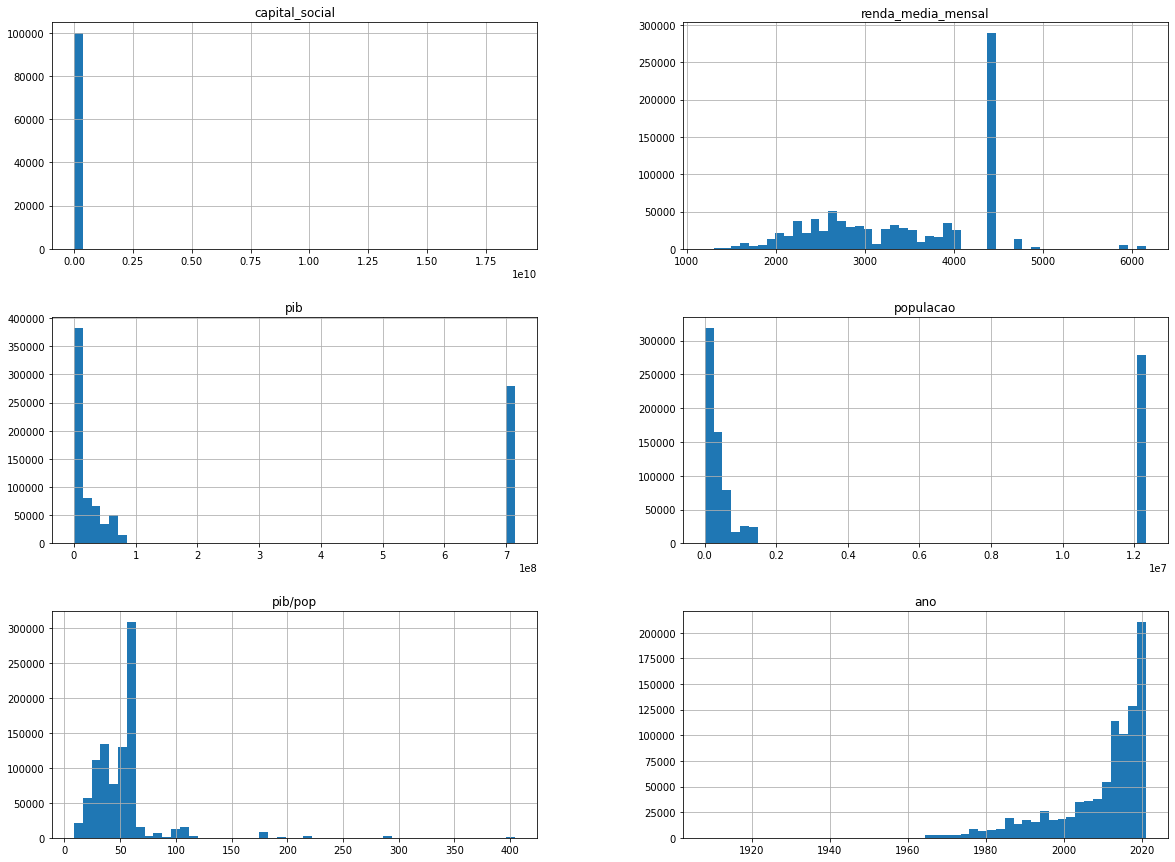

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
%matplotlib inline
train_set['ano'] = train_set['ano'].astype(int)
train_set.hist(bins=50, figsize=(20,15))
plt.pyplot.show()
train_set['ano'] = train_set['ano'].astype(object)

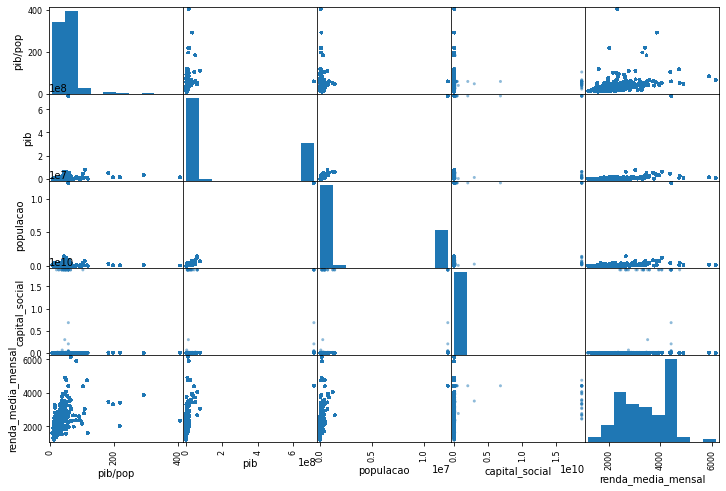

In [ ]:
#scatter matrix
from pandas.plotting import scatter_matrix

attributes = ["pib/pop", "ano", "pib",
              "populacao", 'capital_social', 'renda_media_mensal']
scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.pyplot.show()

cnpj fechados

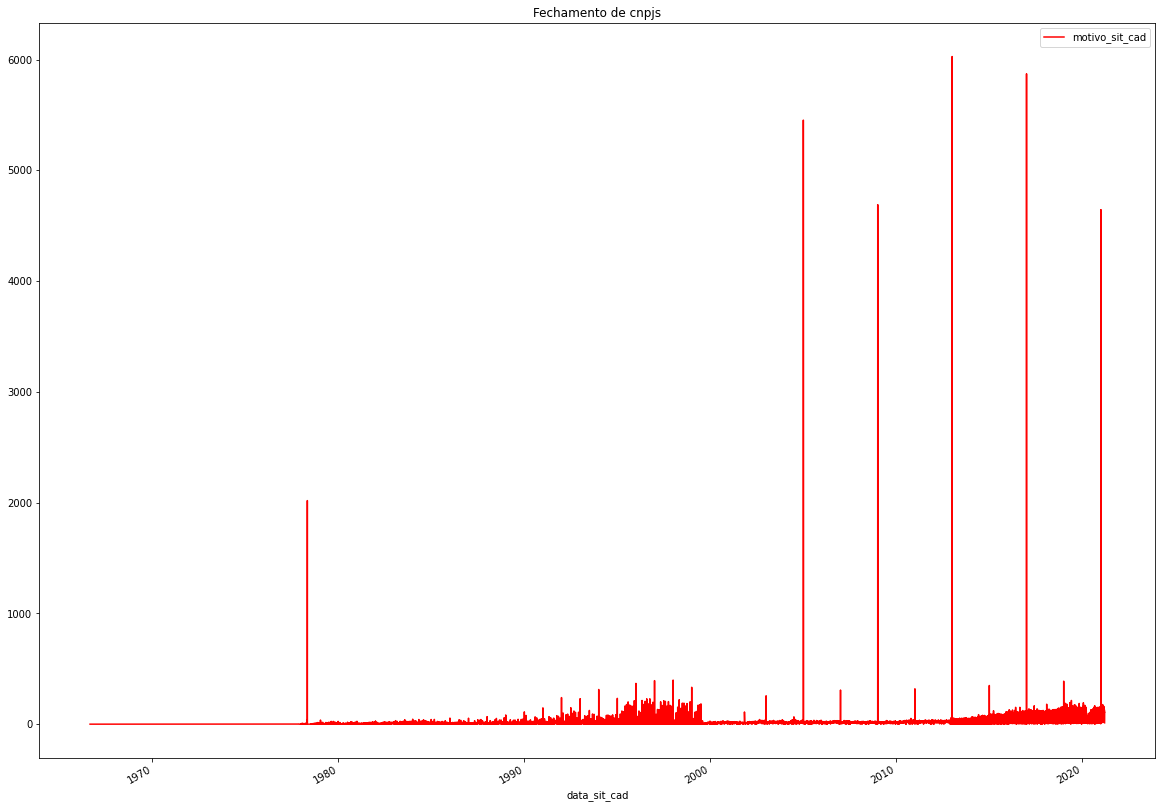

In [ ]:
#cnpj selecionado só que fechou por liquidação voluntária:
cnpj_fechou = train_set[train_set['motivo_sit_cad']=='1']
cnpj_fechou

cnpj_fechou_agrup = cnpj_fechou[['data_sit_cad', 'motivo_sit_cad']].groupby(by='data_sit_cad' ).agg('count') #, as_index=False , se quiser tirar do index as datas
cnpj_fechou_agrup #no dataset antes de deletar os valores nulos, havia 381.769 cnpjs fechados

cnpj_fechou_agrup.plot(kind='line', figsize=(20,15), x_compat=True, color='r', title='Fechamento de cnpjs')

Visto esse pico de baixas de CNPJs de candidatos a cargo político, vamos remove-los do aprendizado do nosso modelo.

In [ ]:
cnpj_fechou_agrup[cnpj_fechou_agrup['motivo_sit_cad']> 1000].T

data_sit_cad,1978-05-02,2004-12-31,2008-12-31,2012-12-31,2016-12-31,2020-12-31
motivo_sit_cad,2019,5453,4690,6027,5871,4645


Eliminar candidatos políticos

In [ ]:
train_set = train_set[train_set['cnae_principal'] != '9492800'].copy() #eliminar tudo que é candidado político eletivo CNAE 9492800

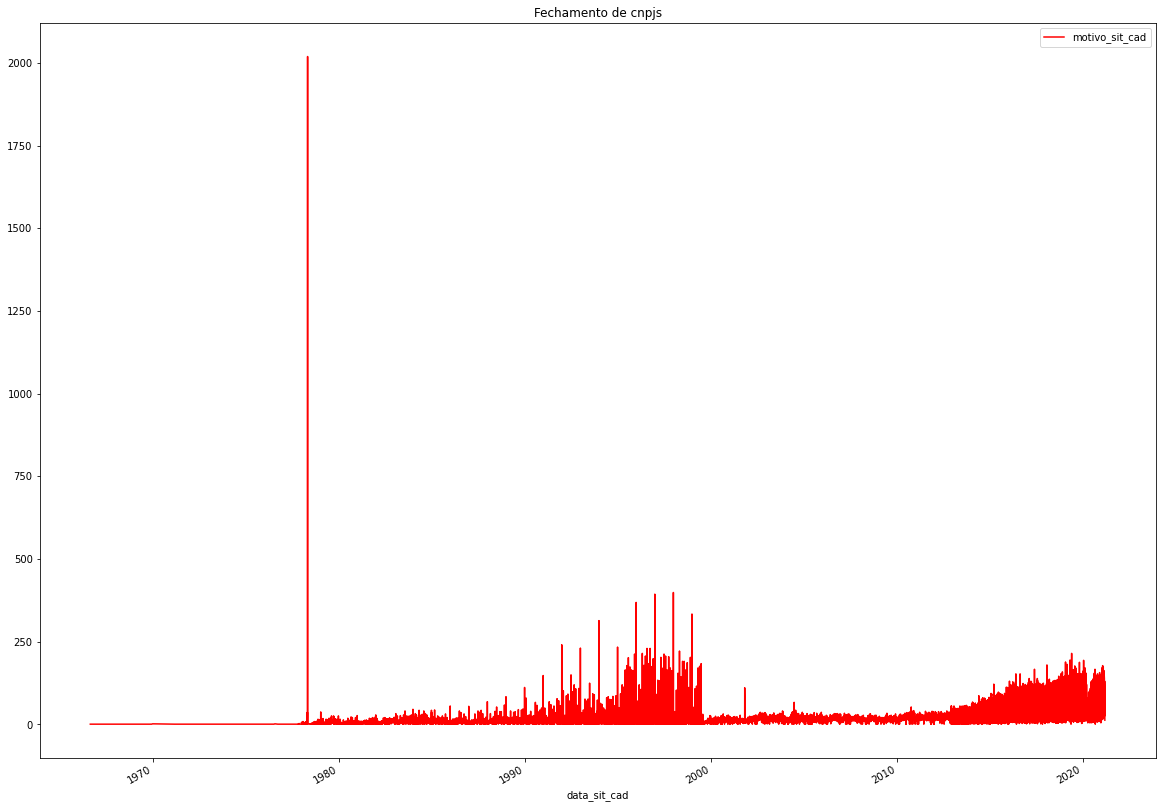

In [ ]:
cnpj_fechou2 = train_set[train_set['motivo_sit_cad']=='1']
cnpj_fechou_agrup2 = cnpj_fechou2[['data_sit_cad', 'motivo_sit_cad']].groupby(by='data_sit_cad' ).agg('count') #
cnpj_fechou_agrup2.plot(kind='line', figsize=(20,15), x_compat=True, color='r', title='Fechamento de cnpjs')

In [ ]:
cnpj_fechou_agrup2[cnpj_fechou_agrup2['motivo_sit_cad'] > 2000] #CNAE DE NAO INFORMADO: 8888888

,motivo_sit_cad
data_sit_cad,
1978-05-02,2019


In [ ]:
train_set[train_set['data_sit_cad'] == '1978-05-02'] #8888888 atividade nao informada

,matriz_filial,data_sit_cad,motivo_sit_cad,inicio_atividade,cnae_principal,tipo,complemento,cep,ddd,tel,ddd2,tel2,dddfax,fax,email,nat_jur,qual_resp,capital_social,porte_empresa,municipio,renda_media_mensal,pib,populacao,contato,pib/pop,ano
38678,1,1978-05-02,1,1966-10-29,8888888,RUA,mi,03010030,0,0,0,0,0,0,0,missing,missing,NaN,missing,SAO PAULO,4427.54,714683362.0,12325232.0,00000000,57.985388,1966
38680,1,1978-05-02,1,1970-04-15,8888888,RUA,mi,04691090,0,0,0,0,0,0,0,missing,missing,NaN,missing,SAO PAULO,4427.54,714683362.0,12325232.0,00000000,57.985388,1970
38681,1,1978-05-02,1,1966-11-03,8888888,RUA,mi,04652050,0,0,0,0,0,0,0,missing,missing,NaN,missing,SAO PAULO,4427.54,714683362.0,12325232.0,00000000,57.985388,1966
38684,1,1978-05-02,1,1969-01-10,8888888,AVENIDA,mi,04447010,0,0,0,0,0,0,0,missing,missing,NaN,missing,SAO PAULO,4427.54,714683362.0,12325232.0,00000000,57.985388,1969
38690,1,1978-05-02,1,1967-05-09,8888888,RUA,mi,04456030,0,0,0,0,0,0,0,missing,missing,NaN,missing,SAO PAULO,4427.54,714683362.0,12325232.0,00000000,57.985388,1967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908381,1,1978-05-02,1,1972-07-05,8888888,RUA,mi,16900053,0,0,0,0,0,0,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,00000000,33.608720,1972
908383,1,1978-05-02,1,1975-04-16,8888888,RUA,mi,16901026,0,0,0,0,0,0,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,00000000,33.608720,1975
908384,1,1978-05-02,1,1976-08-04,8888888,RUA,mi,16901307,0,0,0,0,0,0,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,00000000,33.608720,1976
908436,1,1978-05-02,1,1974-01-14,8888888,RUA,mi,16901010,0,0,0,0,0,0,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,00000000,33.608720,1974


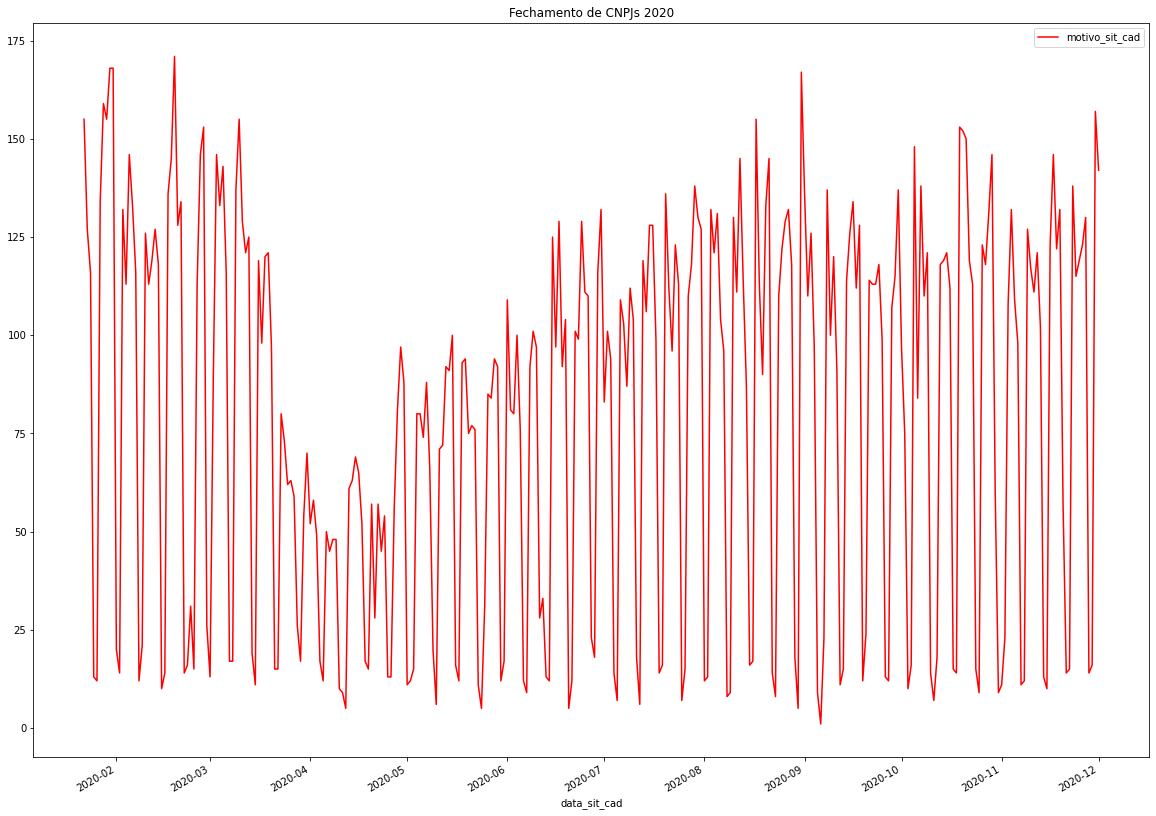

In [ ]:

import matplotlib.pylab as plt
import matplotlib.dates as mdates #para o eixo X não ficar bagunçado
ax = cnpj_fechou_agrup2['20200122':'20201201'].plot(kind='line', figsize=(20,15), x_compat=True, color='r', title='Fechamento de CNPJs 2020')
ax.xaxis.set_major_locator(mdates.MonthLocator()) #para os ticks do eixo x ficaram melhor distribuídos
plt.show()

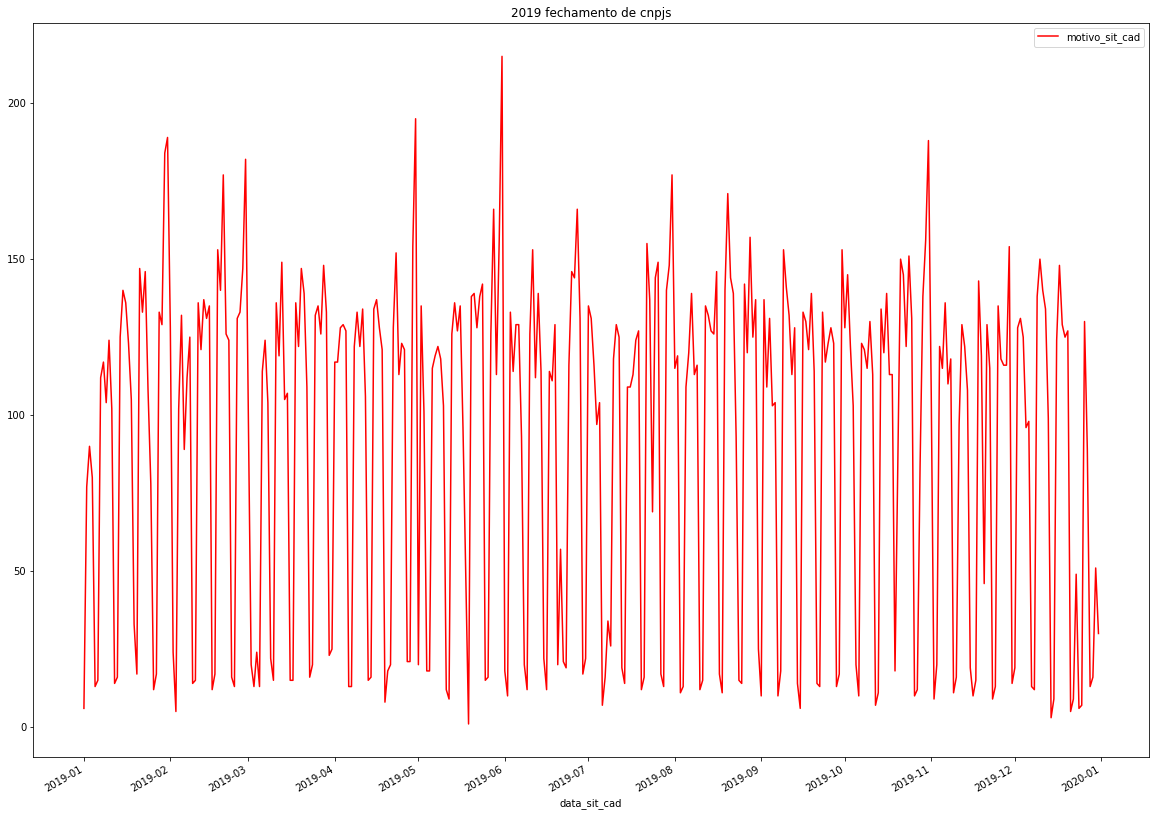

In [ ]:
ax = cnpj_fechou_agrup2['20190101':'20191231'].plot(kind='line', figsize=(20,15), x_compat=True, color='r', title='2019 fechamento de cnpjs')
ax.xaxis.set_major_locator(mdates.MonthLocator()) #para os ticks do eixo x ficaram melhor distribuídos
plt.show()

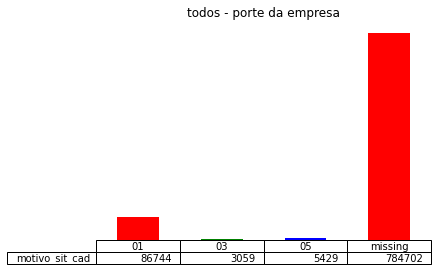

In [ ]:
import matplotlib as plt
train_set.groupby(['porte_empresa']).motivo_sit_cad.count().plot(kind='bar', table=True, color=['r','g','b'], title='todos - porte da empresa')
plt.pyplot.axis('off')
plt.pyplot.show()

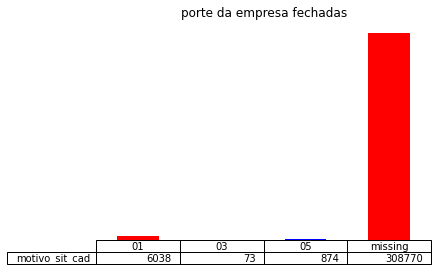

In [ ]:
cnpj_fechou2.groupby(['porte_empresa']).motivo_sit_cad.count().plot(kind='bar', table=True,  color=['r','g','b'], title='porte da empresa fechadas')
plt.pyplot.axis('off')
plt.pyplot.show()

In [ ]:
(6038/86744, 73/3059, 874/5429, 308770/784702)

(0.06960711980079314,
 0.02386400784570121,
 0.1609872904770676,
 0.39348695428328206)

In [ ]:
cnpj_fechou_2020 = cnpj_fechou2[cnpj_fechou2['data_sit_cad'] > '20191231'] 

In [ ]:
vinte_fechadas_cnae = cnpj_fechou_2020.groupby(['cnae_principal']).motivo_sit_cad.count().sort_values(ascending=False).head(20)

In [ ]:
vinte_fechadas_cnae.sort_values(ascending=False)

cnae_principal
4781400    2098
7319002    1446
8219999    1239
5611203    1121
9602501     983
5620104     920
5611201     810
4930201     756
4399103     638
5320202     570
8599699     561
8599604     549
9511800     518
8211300     511
4321500     473
8230001     473
4712100     464
4723700     462
4789099     423
4772500     413
Name: motivo_sit_cad, dtype: int64

In [ ]:
train_set.shape, train_set.shape

((879934, 26), (879934, 26))

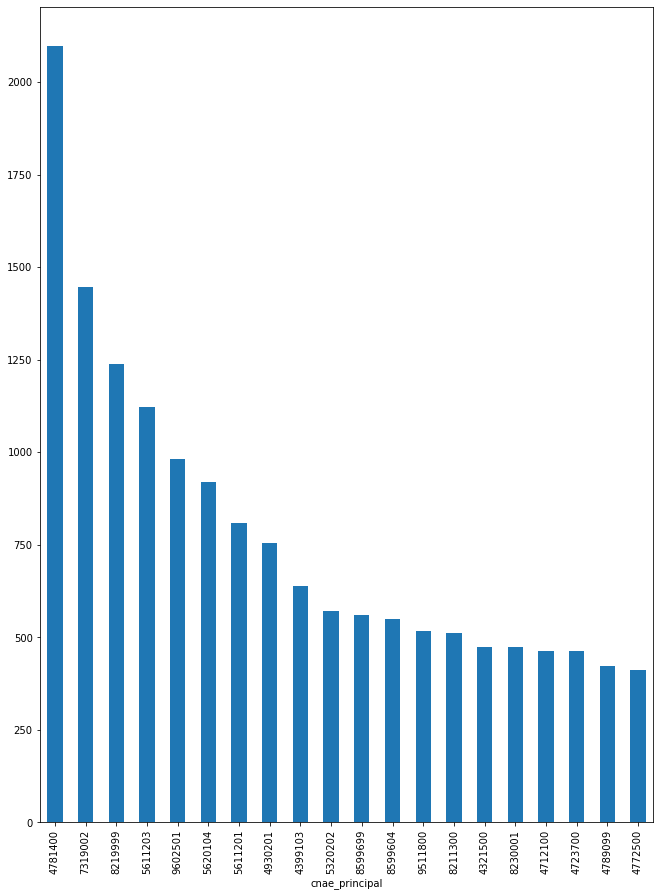

In [ ]:
vinte_fechadas_cnae.plot(kind='bar', figsize=(11,15))
# plt.pyplot.axis('off')
# plt.pyplot.show()

## CNPJs Abertos

In [ ]:
cnpj_abertos = train_set[train_set['motivo_sit_cad']=='0']
cnpjs_abertos_agrupamento = cnpj_abertos[['inicio_atividade', 'motivo_sit_cad']].groupby(by='inicio_atividade' ).agg('count') 
cnpjs_abertos_agrupamento 

,motivo_sit_cad
inicio_atividade,
1908-08-25,1
1917-01-31,1
1927-04-05,1
1929-06-20,1
1934-01-16,1
...,...
2021-03-09,389
2021-03-10,309
2021-03-11,332


In [ ]:
train_set.shape

(879934, 26)

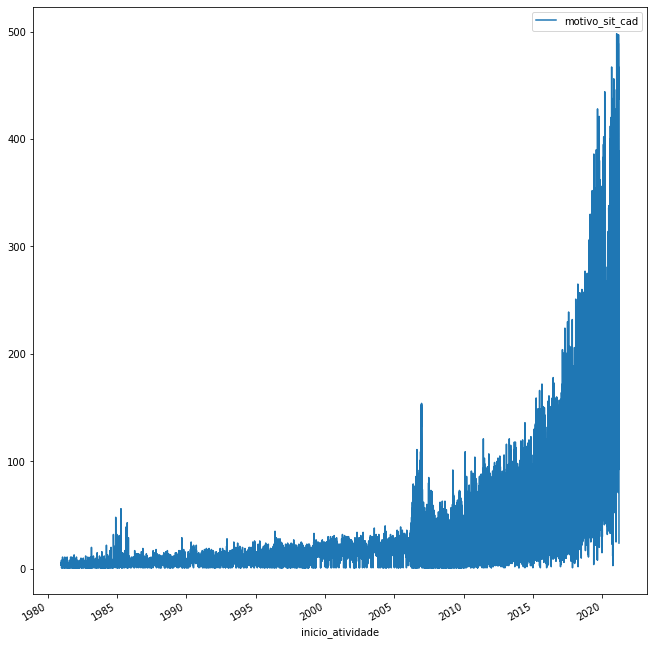

In [ ]:
cnpjs_abertos_agrupamento.iloc[3000:, :].plot(kind='line', figsize=(11,12))

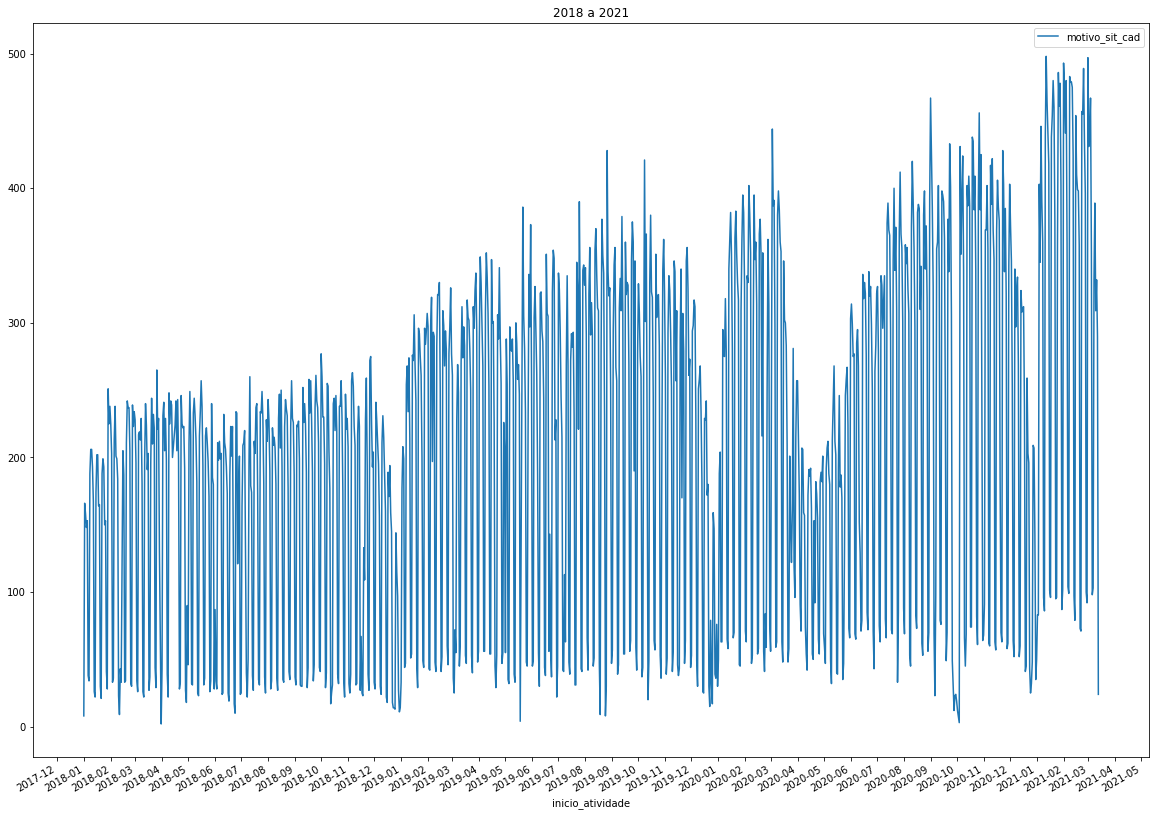

In [ ]:
#Pode-se observar que há uma queda brusca na abertura de cnpjs a partir do mês de março havendo uma recuperação no meses seguintes
#bem diferente do que acontece nos mesmos meses em 2019

import matplotlib as plt
import matplotlib.dates as mdates

ax = cnpjs_abertos_agrupamento['20180101':'20210313'].plot(kind='line', figsize=(20,15), x_compat=True, title='2018 a 2021')
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.pyplot.show()

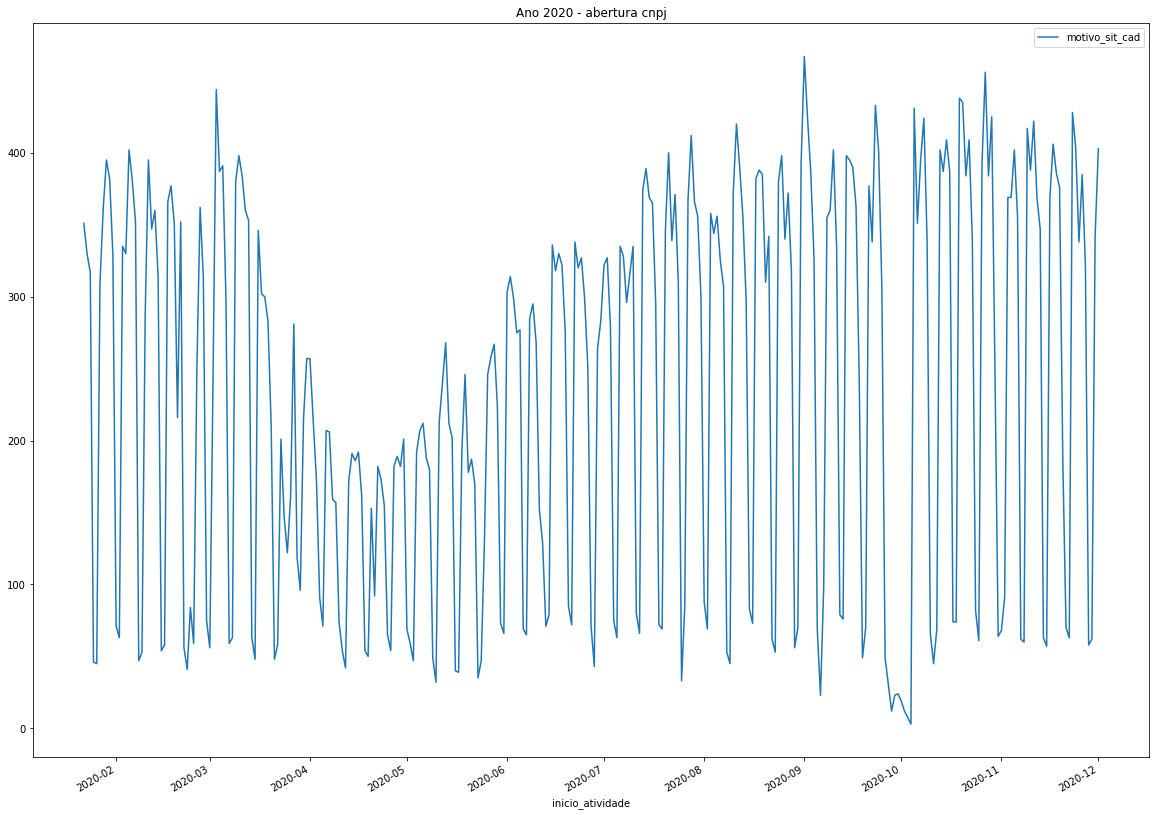

In [ ]:
ax = cnpjs_abertos_agrupamento['20200122':'20201201'].plot(kind='line', figsize=(20,15), x_compat=True, title='Ano 2020 - abertura cnpj')
ax.xaxis.set_major_locator(mdates.MonthLocator()) #para os ticks do eixo x ficaram melhor distribuídos
plt.pyplot.show()

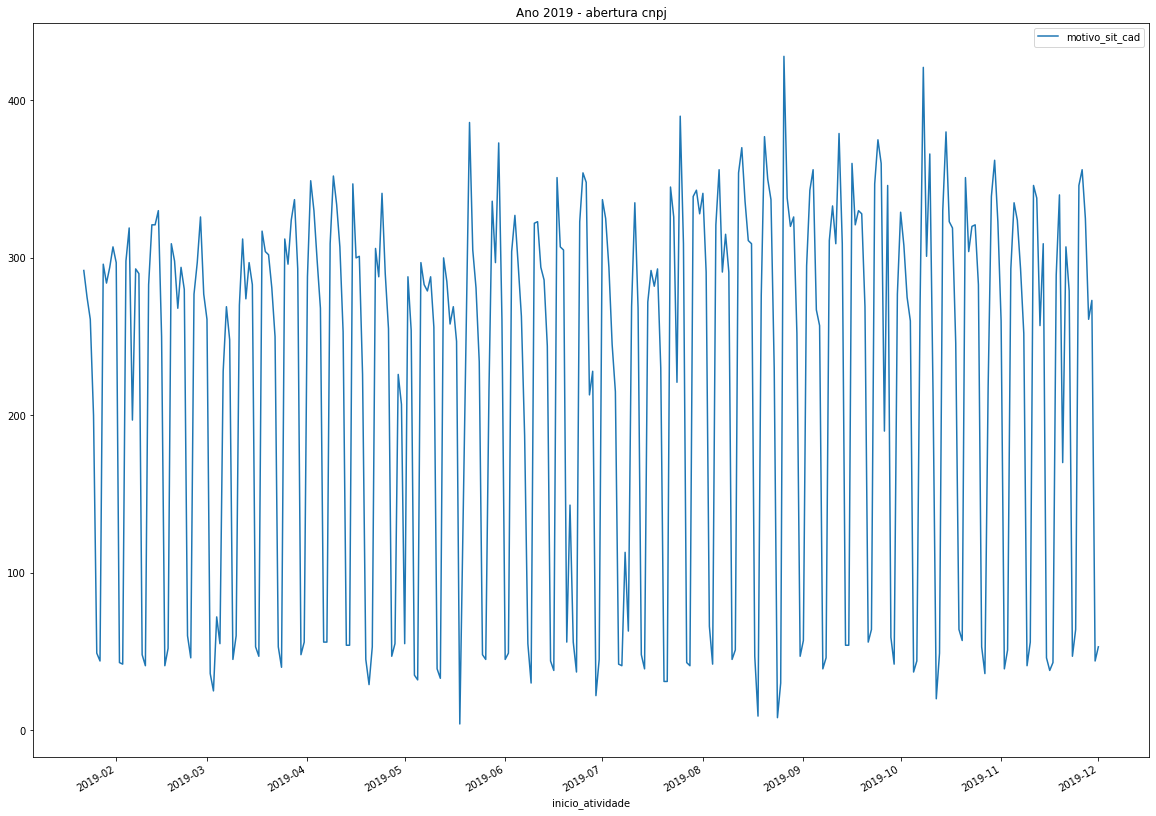

In [ ]:
ax = cnpjs_abertos_agrupamento['20190122':'20191201'].plot(kind='line', figsize=(20,15), x_compat=True, title='Ano 2019 - abertura cnpj')
ax.xaxis.set_major_locator(mdates.MonthLocator()) #para os ticks do eixo x ficaram melhor distribuídos
plt.pyplot.show()

Segundo o Ministério da Economia, houve recorde na abertura de empresas no ano de 2020 e aparentemente a tendência se mantém no ano de 2021
https://economia.uol.com.br/noticias/redacao/2021/02/02/2020-tem-recorde-de-abertura-de-empresas-meis-crescem-em-26-milhoes.htm#:~:text=79%2C3%25%20das%20empresas%20abertas,384%20MEIs%20ativos%20no%20pa%C3%ADs.

In [ ]:
#Dias em que houve mais de 450 cnpjs abertos no Estado de São Paulo
cnpjs_abertos_agrupamento[cnpjs_abertos_agrupamento['motivo_sit_cad'] > 450 ]

,motivo_sit_cad
inicio_atividade,
2020-09-01,467
2020-10-27,456
2021-01-12,498
2021-01-13,464
2021-01-19,454
2021-01-20,480
2021-01-21,460
2021-01-26,486
2021-01-27,461


In [ ]:
cnpj_aberto_2020 = cnpj_abertos[cnpj_abertos['data_sit_cad'] > '20191231']

In [ ]:
mais_abertas_cnpj = cnpj_aberto_2020.groupby(['cnae_principal']).motivo_sit_cad.count().sort_values(ascending=False).head(20)

In [ ]:
mais_abertas_cnpj.sort_values(ascending=False)

cnae_principal
4781400    5538
7319002    4409
9602501    4056
8219999    4000
5620104    3720
4930201    3394
4399103    2792
5611201    2706
5611203    2402
5320202    1835
5229099    1810
4723700    1700
9700500    1698
8599604    1594
8599699    1592
9602502    1581
8211300    1473
4321500    1448
4712100    1271
5612100    1263
Name: motivo_sit_cad, dtype: int64

##Fim de CNPJ ABERTOS

## Inicio de CNPJ ABERTOS E FECHADOS

In [ ]:
copia_cnpj_abertos = cnpjs_abertos_agrupamento.copy()
copia_cnpj_fechados = cnpj_fechou_agrup2.copy()

In [ ]:
cnpj_abriu_fechou = pd.concat([copia_cnpj_abertos, copia_cnpj_fechados], axis=1) #naturalmente haverá dias que há cnpjs abertos e não há fechados e vice versa, daí os NANs
cnpj_abriu_fechou.columns = ['cnpj_abertos', 'cnpj_fechados']
cnpj_abriu_fechou

,cnpj_abertos,cnpj_fechados
1908-08-25,1.0,NaN
1917-01-31,1.0,NaN
1927-04-05,1.0,NaN
1929-06-20,1.0,NaN
1934-01-16,1.0,NaN
...,...,...
2021-03-09,389.0,131.0
2021-03-10,309.0,110.0
2021-03-11,332.0,107.0
2021-03-12,290.0,112.0


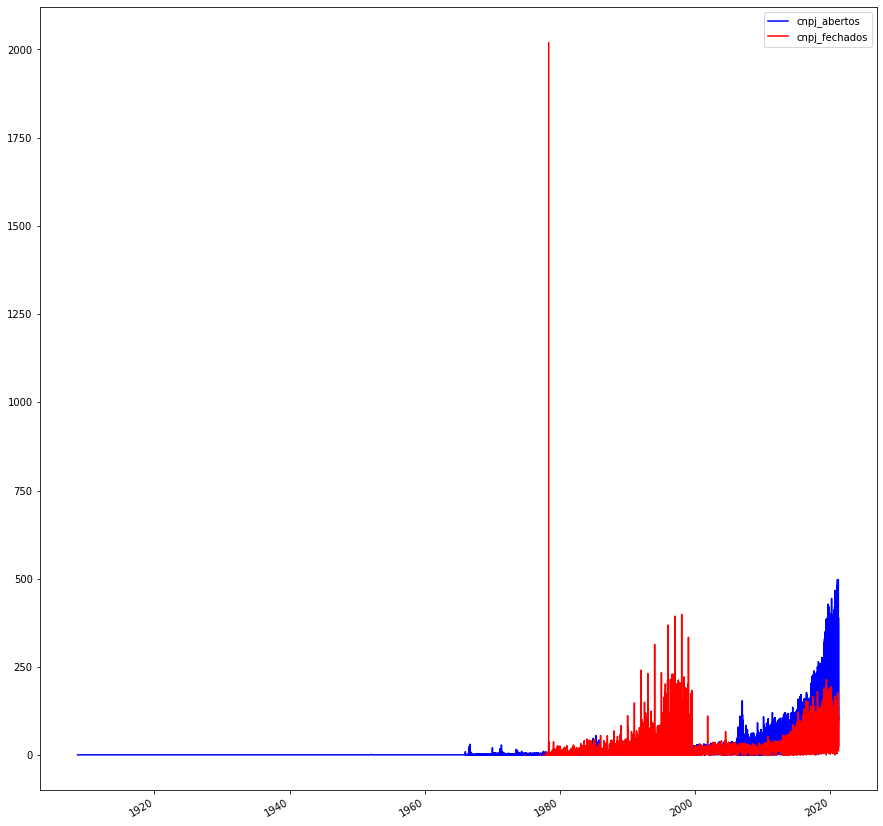

In [ ]:
cnpj_abriu_fechou.plot(kind='line', figsize=(15,16), color=['b','r'])

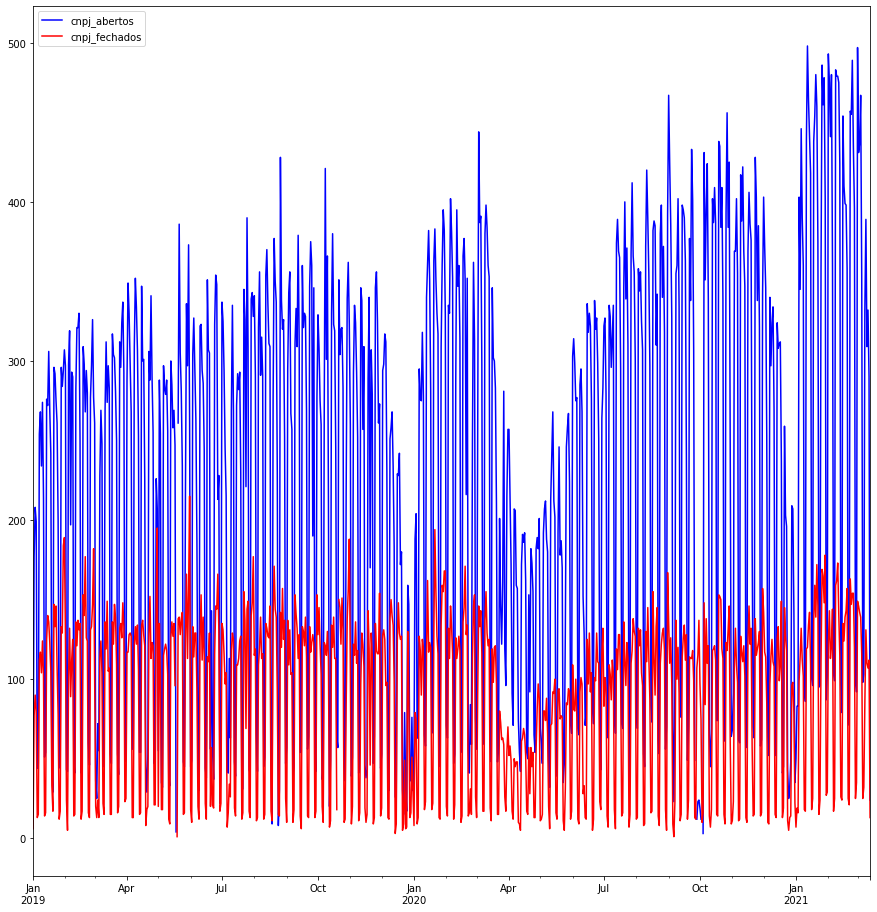

In [ ]:
cnpj_abriu_fechou['20190101':'20210313' ].plot(kind='line', figsize=(15,16), color=['b', 'r'])


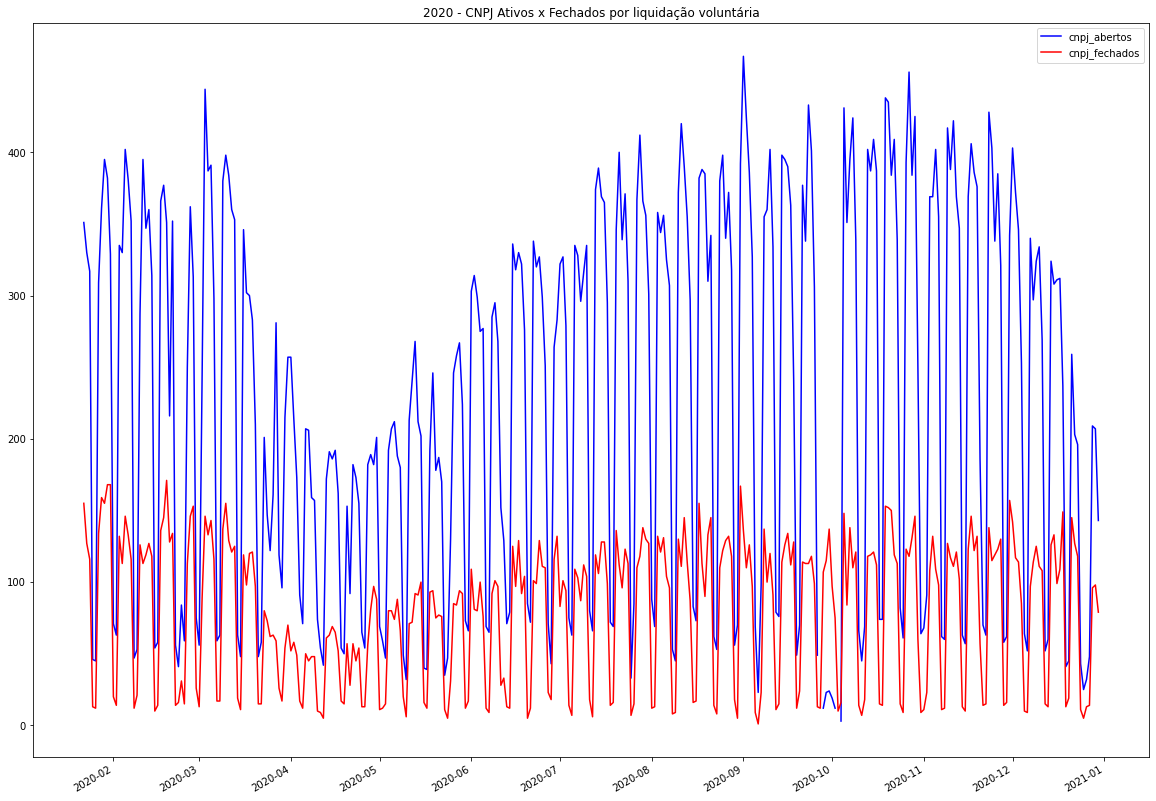

In [ ]:
ax = cnpj_abriu_fechou['20200122':'20201230'].plot(kind='line', figsize=(20,15), x_compat=True, color=['b', 'r'], title='2020 - CNPJ Ativos x Fechados por liquidação voluntária')
ax.xaxis.set_major_locator(mdates.MonthLocator()) #para os ticks do eixo x ficaram melhor distribuídos
plt.pyplot.show()

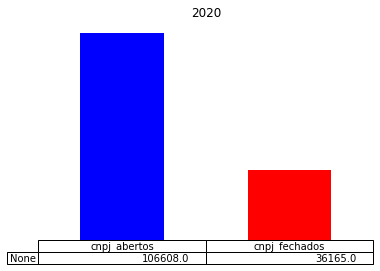

In [ ]:
ano_2020 = cnpj_abriu_fechou['20200101':'20210313'].sum() # periodo de 2020 01 01 a 2021 01 01 por liquidação voluntária
ano_2020.plot(kind='bar', table=True, color=['b','r'], title='2020')
plt.pyplot.axis('off')
plt.pyplot.show()

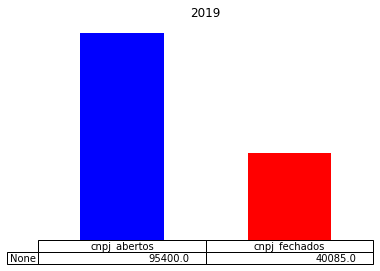

In [ ]:
ano_2019 = cnpj_abriu_fechou['20190101':'20200313'].sum() # periodo de 2020 01 01 a 2021 01 01 por liquidação voluntária
ano_2019.plot(kind='bar', table=True, color=['b','r'] , title='2019', )

plt.pyplot.axis('off')
plt.pyplot.show()

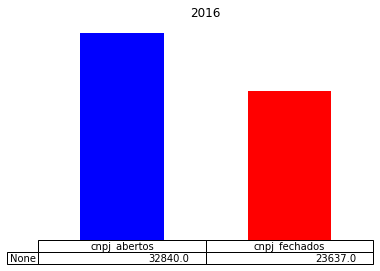

In [ ]:
ano_2016 = cnpj_abriu_fechou['20160101':'20170101'].sum() #ano de 2016-01-01 a 2017 01 01 por liquidação voluntária
ano_2016.plot(kind='bar', table=True, color=['b','r'], title='2016'), 
plt.pyplot.axis('off')
plt.pyplot.show()

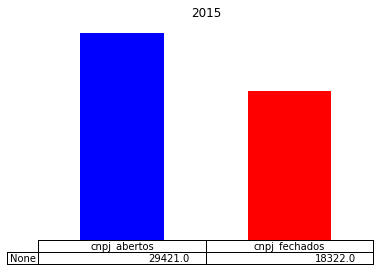

In [ ]:
ano_2016 = cnpj_abriu_fechou['20160101':'20170101'].sum() #ano de 2016-01-01 a 2017 01 01 por liquidação voluntária
ano_2016.plot(kind='bar', table=True, color=['b','r'], title='2016')
#########################################################################################################################
ano_2015 = cnpj_abriu_fechou['20150101':'20160101'].sum() #ano de 2016-01-01 a 2017 01 01 por liquidação voluntária
ano_2015.plot(kind='bar', table=True, color=['b','r'], title='2015')

##########################################################################################################################
plt.pyplot.axis('off')
plt.pyplot.show()

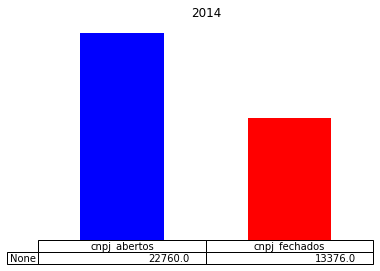

In [ ]:
ano_2014 = cnpj_abriu_fechou['20140101':'20150101'].sum() #
ano_2014.plot(kind='bar', table=True, color=['b','r'], title='2014')
plt.pyplot.axis('off')
plt.pyplot.show()

## Modelagem

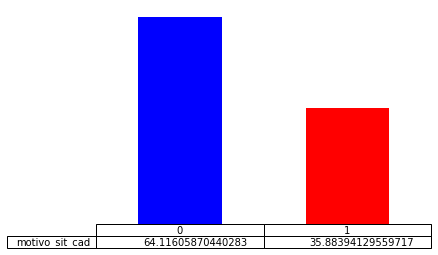

In [ ]:
(train_set['motivo_sit_cad'].value_counts(normalize=True)*100).plot(kind='bar', table=True, color=['b', 'r']) #astype(int).plot(kind='hist', color=['b', 'r'])
plt.pyplot.axis('off')
plt.pyplot.show()

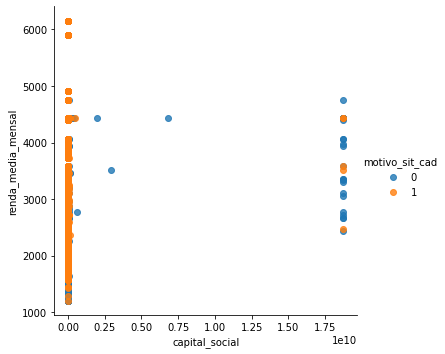

In [ ]:
import seaborn as sns
sns.lmplot(x="capital_social", y="renda_media_mensal", hue='motivo_sit_cad', data=train_set, fit_reg=False, x_jitter=0.1, y_jitter=0.1)

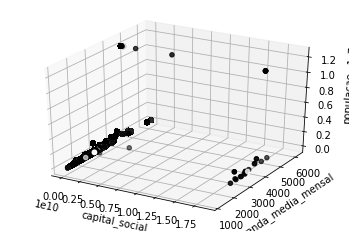

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111, projection = '3d')

x = train_set['capital_social']
y = train_set['renda_media_mensal']
z = train_set['populacao']

ax.set_xlabel("capital_social")
ax.set_ylabel("renda_media_mensal")
ax.set_zlabel("populacao")

ax.scatter(x, y, z, c=train_set['motivo_sit_cad'])

plt.pyplot.show()

Algumas colunas, como natureza juridica (nat_jur), qualificação do responsável (qual_resp), serão transformadas em matrizes esparsas por one hot encoding, pois são variáveis categóricas que precisam ser transformadas em númericas para alguns algoritimos como regressão logística conseguirem aproveitar essas features. Porte da empresa será testado tanto como uma variável númerica quanto uma variável categórica transformada por one hot encoding. Será testado como númerica pois uma empresa classificada como 5 é maior do que uma classificada como 3.



In [ ]:
train_set.describe()

,capital_social,renda_media_mensal,pib,populacao,pib/pop
count,9.523200e+04,879934.000000,8.799340e+05,8.799340e+05,879934.000000
mean,6.123173e+06,3477.011752,2.379472e+08,4.136136e+06,50.484200
std,3.335862e+08,927.692561,3.237691e+08,5.561847e+06,28.256677
min,0.000000e+00,1202.370000,3.383800e+04,1.467000e+03,8.541459
25%,1.000000e+03,2661.790000,5.745311e+06,1.481300e+05,34.845886
50%,1.500000e+03,3470.380000,2.642107e+07,4.507850e+05,50.583018
75%,5.000000e+03,4427.540000,7.146834e+08,1.232523e+07,57.985388
max,1.874441e+10,6157.260000,7.146834e+08,1.232523e+07,404.631087


## Modelagem - cross validation

In [ ]:
#Separar o Y para depois divido-lo em Y train e Y teste
y_train =train_set.loc[: , ['motivo_sit_cad']].copy()
train_set.drop('motivo_sit_cad', axis=1, inplace=True) #Meu X será data modificada

In [ ]:
y_train = np.ravel(y_train) #passo necessário para o scikitlearn ler o y como um array contiguo e nao um datagframe

In [ ]:
y_train.shape, train_set.shape

((879934,), (879934, 25))

A modelagem e a previsão de séries temporais são complicadas e desafiadoras. A suposição de i.i.d (independência distribuída de forma idêntica) não se aplica bem aos dados de séries temporais. Há uma dependência implícita das observações anteriores e, ao mesmo tempo, é mais provável que ocorra um vazamento de dados das variáveis ​​do target/label para as variáveis ​​de atraso, além da não estacionariedade inerente no espaço de dados. Por não estacionariedade, queremos dizer mudanças cintilantes de estatísticas observadas, como média e variância. Fica ainda mais complicado quando se leva em consideração a não linearidade inerente. A validação cruzada é uma metodologia bem estabelecida para escolher o melhor modelo ajustando hiperparâmetros ou realizando a seleção de recursos. Há uma infinidade de estratégias para implementar a validação cruzada ideal. A validação cruzada K-fold é um exemplo comprovado de tais técnicas. No entanto, não é robusto no tratamento de problemas de previsão de séries temporais devido à natureza dos dados conforme explicado acima.

## Seleção do modelo por meio do cross validation:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#selecionar variaveis numericas e categoricas
train_set['ano'] = train_set['ano'].astype(object)
numericas = train_set.select_dtypes(include=np.number).columns.tolist()
categoricas = train_set.select_dtypes(object).columns.tolist()
print(numericas)
print(categoricas)

['capital_social', 'renda_media_mensal', 'pib', 'populacao', 'pib/pop']
['matriz_filial', 'cnae_principal', 'tipo', 'complemento', 'cep', 'ddd', 'tel', 'ddd2', 'tel2', 'dddfax', 'fax', 'email', 'nat_jur', 'qual_resp', 'porte_empresa', 'municipio', 'contato', 'ano']


In [ ]:
categoricas_e_numericas = categoricas + numericas
categoricas_e_numericas

['matriz_filial',
 'cnae_principal',
 'tipo',
 'complemento',
 'cep',
 'ddd',
 'tel',
 'ddd2',
 'tel2',
 'dddfax',
 'fax',
 'email',
 'nat_jur',
 'qual_resp',
 'porte_empresa',
 'municipio',
 'contato',
 'ano',
 'capital_social',
 'renda_media_mensal',
 'pib',
 'populacao',
 'pib/pop']

In [ ]:
train_set.isna().sum() #capital social será tratada no pipeline

matriz_filial              0
data_sit_cad            4844
inicio_atividade           0
cnae_principal             0
tipo                       0
complemento                0
cep                        0
ddd                        0
tel                        0
ddd2                       0
tel2                       0
dddfax                     0
fax                        0
email                      0
nat_jur                    0
qual_resp                  0
capital_social        784702
porte_empresa              0
municipio                  0
renda_media_mensal         0
pib                        0
populacao                  0
contato                    0
pib/pop                    0
ano                        0
dtype: int64

In [ ]:
num_pipeline = Pipeline([
        #('log', log1ptransformer()),
        #('box', power_transform(method='box-cox')),
        ('imputer', SimpleImputer(strategy='median')),
        ('standard', StandardScaler())
        ])


cat_pipeline = Pipeline([                                                   #('imputer', SimpleImputer(strategy='most_frequent')
                         ('one', OneHotEncoder(handle_unknown = "ignore")), #ignore será necessário devido ao grande numero de cnaes, se um cnae
                         #desconhecido aparecer nos ddos de teste, ele não provocará um erro na execução do código. Ele tratará esse cnae desconhecido como 0
                         # e mesmo assim fará uma predição desse input de dados.
                        ])





num_attribs = ['populacao', 'pib', 'renda_media_mensal']

cat_attribs = ['porte_empresa', 'cnae_principal', 'matriz_filial', 'qual_resp',
         'tipo', 'nat_jur', 'fax','ddd2',
         'tel','email']

preprocessamento = ColumnTransformer([
        ("num", num_pipeline, numericas),
        ("cat", cat_pipeline, categoricas)], remainder='passthrough') #remainer passthrough passa as colunas  que nao especifiquei, sem transformações#


logreg = LogisticRegression(random_state=0, max_iter=400, n_jobs=-1)  #instanciar objeto 


################################################################################################################################

filtro = categoricas_e_numericas #DEFINIÇÃO DAS VARIÁVEIS INDEPENDENTES / FEATURES
#filtro = ['populacao', 'pib', 'renda_media_mensal']
################################################################################################################################
#############PRIMEIRO PIPELINE##################################################################################################
clf_ = Pipeline([('preprocessamento', preprocessamento),
                ('logreg', logreg),]
                )

clf_.fit(train_set[filtro], y_train) #selecionei essas colunas para input do meu modelo

###############################################################################################################################

##############################################################################################################################
#############SEGUNDO PIPELINE AGORA COM RANDOM FOREST#########################################################################

rf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=400)

clf_rf = Pipeline([('preprocessamento', preprocessamento),
                   ('randomforest', rf)]
                  )
clf_rf.fit(train_set[filtro], y_train)


###############################################################################################################################


Pipeline(memory=None,
         steps=[('preprocessamento',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

0         300000.0
1           1000.0
2          50000.0
3           3000.0
4         104500.0
            ...   
908717         NaN
908718         NaN
908719         NaN
908720         NaN
908739         NaN
Name: capital_social, Length: 879934, dtype: float64

In [ ]:
clf_

Pipeline(memory=None,
         steps=[('preprocessamento',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                  

In [ ]:
from sklearn import set_config
set_config(display='diagram')
clf_

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  ['capital_social',
                                                   'renda_media_mensal', 'pib',
                                                   'populacao', 'pib/pop',
                                                   'ano']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['matriz_filial',
                                                   'cnae_principal', 'tipo',
                                                   'complemento', 'cep', 'ddd',
                                                   'tel', 'ddd2', 'tel2',
                                                   'dddfax', 'fax', 'email',
                                                   'nat_jur', 'qual_resp',
                                                   'porte_empresa', 'municipio',
                                                   'contato'])])),
                ('logreg',
                 LogisticRegression(max_iter=400, n_jobs=-1, random_state=0))])

In [ ]:
clf_rf

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard',
                                                                   StandardScaler())]),
                                                  ['capital_social',
                                                   'renda_media_mensal', 'pib',
                                                   'populacao', 'pib/pop',
                                                   'ano']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['matriz_filial',
                                                   'cnae_principal', 'tipo',
                                                   'complemento', 'cep', 'ddd',
                                                   'tel', 'ddd2', 'tel2',
                                                   'dddfax', 'fax', 'email',
                                                   'nat_jur', 'qual_resp',
                                                   'porte_empresa', 'municipio',
                                                   'contato'])])),
                ('randomforest',
                 RandomForestClassifier(max_depth=2, n_estimators=400,
                                        random_state=0))])

CROSS VAL RANDOM FOREST

In [ ]:
############CROSS VALIDATION DO RANDOM FOREST#############################################
scores_1 = cross_val_score(clf_rf, train_set[filtro], y_train,cv=tss , scoring='roc_auc')
scores_mean = scores_1.mean()
scores_mean

0.7300971086207809

CROSS VAL REGRESSAO LOGISTICA

In [ ]:
################### CROSS VALIDATION DA REGRESSAO LOGISTICA #################################
scores_logistica = cross_val_score(clf_, train_set[filtro], y_train,cv=tss , scoring='roc_auc')
scores_mean_logistica = scores_logistica.mean()

scores_mean_logistica

0.5196746273489641

In [ ]:
# from sklearn.dummy import DummyClassifier

# dummy_clf = DummyClassifier(strategy="most_frequent")

# clf_dummy = Pipeline([('preprocessamento', preprocessamento),
#                 ('dummy', dummy_clf),]
#                 )
# clf_dummy.fit(train_set[filtro], y_train)
# clf_dummy.score(train_set[filtro], y_train)

# d = cross_val_score(clf_dummy, train_set[filtro], y_train,cv=tss , scoring='roc_auc')
# d_mean = d.mean()
# d_mean

0.5

In [ ]:
import joblib
#salvar RREGRESSAO LOGISTICA, MODELO TREINADO

joblib.dump([scores_mean_logistica,clf_,filtro, scores_logistica], f'/content/drive/MyDrive/Colab Notebooks/tcc/{scores_mean_logistica}desbalanced_logistica.pkl')


['/content/drive/MyDrive/Colab Notebooks/tcc/0.7819757387717495desbalanced_logistica.pkl']

In [ ]:
import joblib

#salvar RANDOM FOREST, MODELO TREINADO

joblib.dump([clf_rf,scores_1, scores_mean, filtro], f'/content/drive/MyDrive/Colab Notebooks/tcc/{scores_mean}randomforest_todas_var29042021.pkl')

# ranking_ndarray of shape (n_features,)
# The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

['/content/drive/MyDrive/Colab Notebooks/tcc/0.7300971086207809randomforest_todas_var29042021.pkl']

In [ ]:
np.set_printoptions(threshold=np.inf)


Meus modelos, scores e variáveis selecionadas salvas no joblib/pickle

In [ ]:
#Resultado salvo de regressao logistica:
regressao_logistica_score = joblib.load(f'/content/drive/MyDrive/Colab Notebooks/tcc/{score_mean}regressao_logistica_score{st}.pkl')

regressao_logistica_score

[array([0.65850238, 0.77722172, 0.80607504, 0.82664299, 0.87246708]),
 Pipeline(memory=None,
          steps=[('preprocessamento',
                  ColumnTransformer(n_jobs=None, remainder='passthrough',
                                    sparse_threshold=0.3,
                                    transformer_weights=None,
                                    transformers=[('cat',
                                                   Pipeline(memory=None,
                                                            steps=[('imputer',
                                                                    SimpleImputer(add_indicator=False,
                                                                                  copy=True,
                                                                                  fill_value=None,
                                                                                  missing_values=nan,
                                                                    

## TEST SET

In [ ]:
from sklearn.metrics import roc_auc_score

## tratamento do test set

In [ ]:
test_set = test_set[test_set['cnae_principal'] != '9492800'].copy() #eliminar tudo que é candidado político eletivo CNAE 9492800 

In [ ]:
#Vamos transformar nans em zeros e o restante em 1, ou seja, tornar a feature binária
insta = feat_binario1()
test_set.loc[:, ['ddd', 'tel', 'ddd2', 'tel2', 'dddfax', 'fax', 'email']] = insta.fit_transform(test_set.loc[:, ['ddd', 'tel', 'ddd2', 'tel2', 'dddfax', 'fax', 'email']])
test_set.loc[:, ['ddd', 'tel', 'ddd2', 'tel2', 'dddfax', 'fax', 'email']]

,ddd,tel,ddd2,tel2,dddfax,fax,email
908742,1,1,0,0,0,0,1
908750,1,1,1,1,1,1,1
908751,1,1,0,0,1,1,1
908752,1,1,0,0,0,0,1
908753,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1009709,1,1,1,1,1,1,1
1009710,1,1,0,0,1,1,1
1009711,1,1,0,0,0,0,1
1009712,1,1,0,0,0,0,1


In [ ]:
#missing values 
test_set.isna().sum()

matriz_filial             0
data_sit_cad            394
motivo_sit_cad            0
inicio_atividade          0
cnae_principal            0
tipo                    510
complemento           61683
cep                       0
ddd                       0
tel                       0
ddd2                      0
tel2                      0
dddfax                    0
fax                       0
email                     0
nat_jur               81943
qual_resp             81943
capital_social        81943
porte_empresa         81943
municipio                 0
renda_media_mensal        0
pib                       0
populacao                 0
dtype: int64

## Variaveis complemento e tipo mesmo tratamento dado ao conjunto de treinamento




In [ ]:
test_set[['tipo', 'complemento']].isna().sum()

tipo             510
complemento    61683
dtype: int64

In [ ]:
test_set.loc[:, ['tipo', 'complemento']] = test_set.loc[:, ['tipo', 'complemento']].fillna('missing')

## Variavel capital social, porte, natureza juridica e qual resp fillina; já data_sit_cad nao será usada no modelo

In [ ]:
#fillna:
test_set.loc[:, ['porte_empresa', 'nat_jur', 'qual_resp']] = test_set.loc[:, ['porte_empresa', 'nat_jur', 'qual_resp']].fillna('missing')

In [ ]:
test_set[['tipo', 'complemento', 'porte_empresa', 'nat_jur', 'qual_resp']]

,tipo,complemento,porte_empresa,nat_jur,qual_resp
908742,RUA,CASA,missing,missing,missing
908750,RUA,missing,missing,missing,missing
908751,RUA,missing,missing,missing,missing
908752,RUA,missing,missing,missing,missing
908753,RUA,missing,missing,missing,missing
...,...,...,...,...,...
1009709,RUA,missing,missing,missing,missing
1009710,FAZENDA,missing,05,4120,59
1009711,RUA,missing,01,2135,50
1009712,RUA,missing,01,2135,50


In [ ]:
test_set[['tipo', 'complemento', 'porte_empresa', 'nat_jur', 'qual_resp']].isna().sum()

tipo             0
complemento      0
porte_empresa    0
nat_jur          0
qual_resp        0
dtype: int64

In [ ]:
test_set['cep'] = test_set['cep'].fillna(method='ffill')

In [ ]:
test_set.isna().sum()

matriz_filial             0
data_sit_cad            394
motivo_sit_cad            0
inicio_atividade          0
cnae_principal            0
tipo                      0
complemento               0
cep                       0
ddd                       0
tel                       0
ddd2                      0
tel2                      0
dddfax                    0
fax                       0
email                     0
nat_jur                   0
qual_resp                 0
capital_social        81943
porte_empresa             0
municipio                 0
renda_media_mensal        0
pib                       0
populacao                 0
dtype: int64

## Fim de imputação. Inicio de Feature engineering





In [ ]:
test_set.loc[: , 'tipo'] = test_set.loc[:, 'tipo'].str.replace(r'^\d[^ ]* ', '').str.strip() #.value_counts().sort_index()

In [ ]:
Xteste = test_set.copy() #copia de segurança!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
test_set['complemento'] = test_set['complemento'].str.replace(r'\d+', '').str.strip() #remove espaços no inicio e fim da string

In [ ]:
test_set['complemento'] = test_set['complemento'].str.extract(r'\b([a-zA-Z]{,20})\b').fillna('numero') #Numero PORQUE havia valores dentro de complemento que eram números, dos mais variados, aumentando muito a cardinalidade, logo só quero o que é mais comum.

In [ ]:
test_set['complemento'].nunique()

576

In [ ]:
#Vamos reduzir mais, pegando só as 2 primeiras letras do complemento
test_set['complemento'] = test_set['complemento'].str[:2]

In [ ]:
test_set['complemento'].value_counts().head(20), test_set['complemento'].nunique()

(mi    61683
 CA     4539
 ZO     2960
 SA     2614
 SI     2310
 KM     1944
 LO     1475
 FU     1160
 ES      950
 FA      925
 CO      862
 A       573
 SE      547
 RU      516
 AN      426
 CH      360
 TE      355
 CX      334
 LE      293
 nu      284
 Name: complemento, dtype: int64, 169)

In [ ]:
test_set['capital_social'] = test_set['capital_social'].str.replace(',', '.')  # evita o erro 'ValueError: could not convert string to float: '000000300000,00'

colunas_para_mudar_dtype = ['capital_social', 
                           'pib', 'populacao', 'renda_media_mensal']
                          
muda = muda_dtype()
test_set[colunas_para_mudar_dtype] = muda.fit_transform(test_set[colunas_para_mudar_dtype])
test_set

,matriz_filial,data_sit_cad,motivo_sit_cad,inicio_atividade,cnae_principal,tipo,complemento,cep,ddd,tel,ddd2,tel2,dddfax,fax,email,nat_jur,qual_resp,capital_social,porte_empresa,municipio,renda_media_mensal,pib,populacao
908742,1,2017-03-10,1,2012-07-13,8712300,RUA,CA,16901022,1,1,0,0,0,0,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
908750,1,2009-07-21,1,2007-01-30,7119701,RUA,mi,16900017,1,1,1,1,1,1,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
908751,1,2009-02-04,0,2009-02-04,3314717,RUA,mi,16905210,1,1,0,0,1,1,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
908752,1,2014-06-16,1,2010-03-23,4512902,RUA,mi,16900040,1,1,0,0,0,0,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
908753,1,2016-10-20,1,2012-08-28,4781400,RUA,mi,16900010,1,1,0,0,0,0,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009709,1,2019-11-25,0,2019-11-25,6110803,RUA,mi,17475000,1,1,1,1,1,1,1,missing,missing,NaN,missing,LUCIANOPOLIS,2458.57,57006.0,2403.0
1009710,1,2020-02-06,0,2020-02-06,151203,FAZENDA,mi,17479899,1,1,0,0,1,1,1,4120,59,0.0,05,LUCIANOPOLIS,2458.57,57006.0,2403.0
1009711,1,2020-07-01,0,2020-07-01,4712100,RUA,mi,17475021,1,1,0,0,0,0,1,2135,50,1000.0,01,LUCIANOPOLIS,2458.57,57006.0,2403.0
1009712,1,2020-07-30,0,2020-07-30,4744005,RUA,mi,17475001,1,1,0,0,0,0,1,2135,50,80000.0,01,LUCIANOPOLIS,2458.57,57006.0,2403.0


In [ ]:
test_set['contato'] = test_set['tel'] + test_set['tel2'] + test_set['fax'] + test_set['ddd'] + test_set['ddd2'] + test_set['tel2'] + test_set['dddfax'] + test_set['email']
test_set['contato']

908742     10010001
908750     11111111
908751     10110011
908752     10010001
908753     10010000
             ...   
1009709    11111111
1009710    10110011
1009711    10010001
1009712    10010001
1009713    10010001
Name: contato, Length: 88153, dtype: object

In [ ]:
#criando a variável pib/populacao
test_set['pib/pop'] = test_set['pib']/test_set['populacao']
test_set

,matriz_filial,data_sit_cad,motivo_sit_cad,inicio_atividade,cnae_principal,tipo,complemento,cep,ddd,tel,ddd2,tel2,dddfax,fax,email,nat_jur,qual_resp,capital_social,porte_empresa,municipio,renda_media_mensal,pib,populacao,contato,pib/pop
908742,1,2017-03-10,1,2012-07-13,8712300,RUA,CA,16901022,1,1,0,0,0,0,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10010001,33.608720
908750,1,2009-07-21,1,2007-01-30,7119701,RUA,mi,16900017,1,1,1,1,1,1,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,11111111,33.608720
908751,1,2009-02-04,0,2009-02-04,3314717,RUA,mi,16905210,1,1,0,0,1,1,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10110011,33.608720
908752,1,2014-06-16,1,2010-03-23,4512902,RUA,mi,16900040,1,1,0,0,0,0,1,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10010001,33.608720
908753,1,2016-10-20,1,2012-08-28,4781400,RUA,mi,16900010,1,1,0,0,0,0,0,missing,missing,NaN,missing,ANDRADINA,2722.96,1922486.0,57202.0,10010000,33.608720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009709,1,2019-11-25,0,2019-11-25,6110803,RUA,mi,17475000,1,1,1,1,1,1,1,missing,missing,NaN,missing,LUCIANOPOLIS,2458.57,57006.0,2403.0,11111111,23.722846
1009710,1,2020-02-06,0,2020-02-06,151203,FAZENDA,mi,17479899,1,1,0,0,1,1,1,4120,59,0.0,05,LUCIANOPOLIS,2458.57,57006.0,2403.0,10110011,23.722846
1009711,1,2020-07-01,0,2020-07-01,4712100,RUA,mi,17475021,1,1,0,0,0,0,1,2135,50,1000.0,01,LUCIANOPOLIS,2458.57,57006.0,2403.0,10010001,23.722846
1009712,1,2020-07-30,0,2020-07-30,4744005,RUA,mi,17475001,1,1,0,0,0,0,1,2135,50,80000.0,01,LUCIANOPOLIS,2458.57,57006.0,2403.0,10010001,23.722846


In [ ]:
test_set['ano'] = test_set['inicio_atividade'].dt.year

In [ ]:
test_set['ano'].min(), test_set['ano'].max()

(1960, 2021)

In [ ]:
test_set['ano'] = test_set['ano'].astype(object)

In [ ]:
#Separar as features da label
y_test = test_set.loc[: , ['motivo_sit_cad']].copy()
test_set.drop('motivo_sit_cad', axis=1, inplace=True) #Meu X será data modificada
y_test.shape, test_set.shape

((88153, 1), (88153, 25))

In [ ]:
y_test = np.ravel(y_test)

## Fim do tratamento do test set ( o restante, ohe, simpleimputer, o pipeline cuida)

```
# Isto está formatado como código
```



In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
pred_log = clf_.predict_proba(test_set[filtro])
roc_auc_score(y_test, pred_log[:, 1])

0.8744612651005692

In [ ]:
pred_log = clf_.predict(test_set[filtro])
predict_dec_fun = clf_.decision_function(test_set[filtro])
roc_auc_score(y_test, predict_dec_fun)

0.5454445242917055

TEST SET RANDOM FOREST

In [ ]:
pred_rf = clf_rf.predict_proba(test_set[filtro])
roc_auc_score(y_test, pred_rf[:, 1])

0.8175958442047329

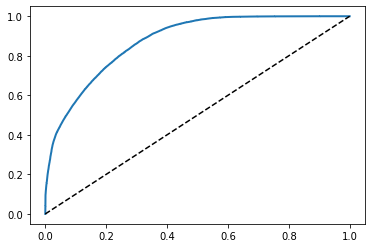

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test,pred_log[:,1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.pyplot.plot(fpr, tpr, linewidth=2, label=label)
    plt.pyplot.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.pyplot.show()

In [ ]:
from sklearn.metrics import roc_curve


In [ ]:
pip install eli5

     |████████████████████████████████| 112kB 12.6MB/s 


In [ ]:
from eli5 import show_weights
from eli5 import show_prediction

In [ ]:
show_weights(logreg)

In [ ]:
X=preprocessamento.fit_transform(train_set[filtro])

In [ ]:
show_prediction(logreg, doc=X[1], top=10, show_feature_values =True) #show_feature_values 